In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Join entre Stress e Feedbacks


feedbacks = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
stress = pd.read_csv("Stress 17_08 - video_sessions_stressfeedback.csv", parse_dates=['created_date'])

feedbacks_stress = pd.DataFrame()

feedbacks['estresse'] = np.zeros(len(feedbacks))

for i in range(len(stress)):
    if type(stress.iloc[i]['session_id']) == str:
        feeds_to_add = feedbacks[ feedbacks['session_id'] == stress.iloc[i]['session_id'] ]
        
    else:
        feeds_to_add = feedbacks[ feedbacks['email'] == stress.iloc[i]['email'] ]
      
    feeds_to_add['estresse'] = stress.loc[i, 'estresse']
    feedbacks_stress = feedbacks_stress.append(feeds_to_add)
    


In [2]:
# Join entre Stress e Feedbacks

feedbacks = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
stress = pd.read_csv("Stress 17_08 - video_sessions_stressfeedback.csv", parse_dates=['created_date'])

stress_sid = stress[pd.notna(stress['session_id'])] # pega os que tem session_id preenchido
stress_email = stress[pd.notna(stress['email'])] # pega os que tem email preenchido
stress_email = stress_email[ ~stress_email['session_id'].isin(stress_sid['session_id']) ] # pega os que tem email sem session_id
stress_final = pd.concat([stress_sid, stress_email])

feedbacks_stress = pd.merge(feedbacks, stress_final, on=['session_id', 'email'], how='inner')
feedbacks_stress.drop(columns = ['created_date_y', 'num_sessao_y'], inplace=True)
feedbacks_stress.rename(index=str, columns={'created_date_x':'created_date', 'num_sessao_x':'num_sessao'}, inplace=True)

In [3]:
#normaliza os dados da versao 1 para range de 5
def normalize_v1(feedbacks):
    feedbacks.loc[feedbacks['versao'] == 1, ['incomodo', 'interesse1', 'interesse2'] ] //= 2
    return feedbacks

feedbacks_stress = normalize_v1(feedbacks_stress)

In [4]:
# inversao dos valores das sessoes que tem o primeiro video com QoS alta

def swap_ints(feedbacks):
    feedbacks = feedbacks.reset_index(drop=True)

    for i in range(len(feedbacks.index)):
        if feedbacks.loc[i, 'created_date'].month < 7:
            if feedbacks.loc[i]['num_sessao'] in (1, 3, 6):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']
                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1                   
        else:

            if feedbacks.loc[i, 'num_sessao'] in (1, 5):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']

                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1
    return feedbacks

feedbacks_stress = swap_ints(feedbacks_stress)

In [5]:
#estatisticas basicas
feedbacks_stress.describe()

# print(feedbacks_stress.loc[7, ['incomodo', 'interesse1', 'interesse2', 'num_video_preferido', 'justificativa']])

,id_x,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,english_x,versao,id_y,estresse,english_y
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,163.250000,4.129032,1.439516,3.637097,3.193548,2.479839,0.012097,1.854839,58.310484,6.806452,0.012097
std,77.268827,2.057740,0.497332,1.271517,1.389244,1.566216,0.109539,0.352976,38.625320,2.413449,0.109539
min,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,101.750000,2.000000,1.000000,3.000000,2.000000,1.000000,0.000000,2.000000,25.000000,5.000000,0.000000
50%,162.500000,4.000000,1.000000,4.000000,3.500000,3.000000,0.000000,2.000000,55.000000,7.000000,0.000000
75%,233.250000,6.000000,2.000000,5.000000,4.000000,4.000000,0.000000,2.000000,94.000000,8.000000,0.000000
max,295.000000,7.000000,2.000000,5.000000,5.000000,5.000000,1.000000,2.000000,125.000000,10.000000,1.000000


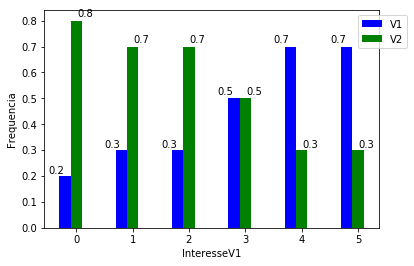

In [6]:
# grafico (interessev1 x preferencia/escolha usuario)

counts = feedbacks_stress.groupby(['interesse1','num_video_preferido'], as_index=False).size().unstack(fill_value=0).reset_index()
counts['V1_percent'] = round(counts[1]/(counts[1]+counts[2]), 1)
counts['V2_percent'] = round(counts[2]/(counts[1]+counts[2]), 1)

ax = plt.subplot()
b1 = ax.bar(counts['interesse1']-0.2, counts['V1_percent'],width=0.2,color='b',align='center')
b2 = ax.bar(counts['interesse1'], counts['V2_percent'],width=0.2,color='g',align='center')


leg = plt.legend((b1[0], b2[0]), ('V1', 'V2'), loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.1
bb.x0 += xOffset
bb.x1 += xOffset

leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.ylabel('Frequencia')
plt.xlabel('InteresseV1')


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(b1, "left")
autolabel(b2, "right")
plt.show()

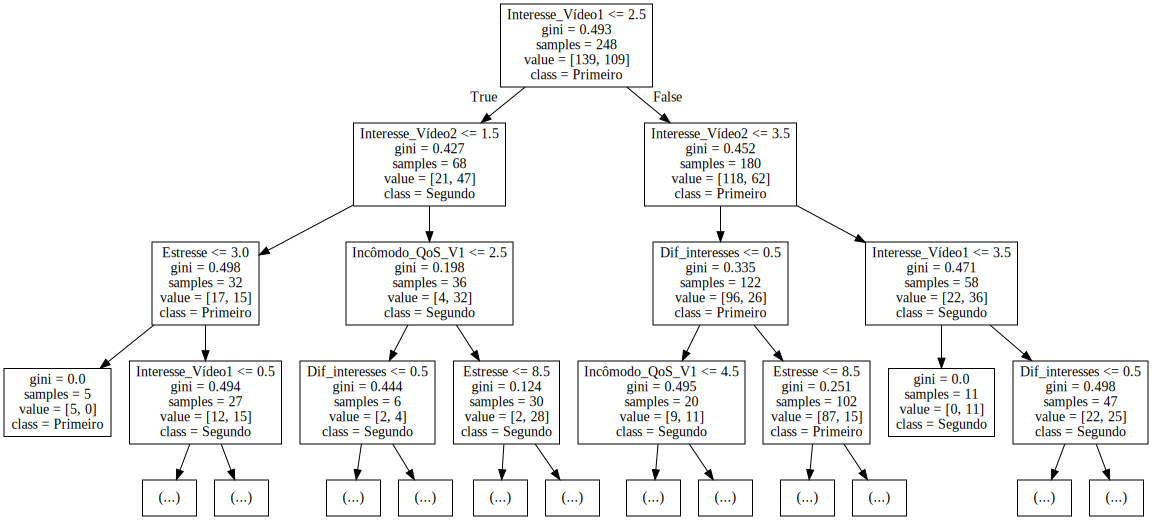

In [75]:
#Arvore de decisao
def arvore(feedbacks, stress=False):
    clf = tree.DecisionTreeClassifier()
    feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses']
    feedbacks['dif_interesses'] = abs(feedbacks['interesse1'] - feedbacks['interesse2'])
    X = np.array([feedbacks['incomodo'], feedbacks['interesse1'], 
                  feedbacks['interesse2'], feedbacks['dif_interesses'] ]).transpose()

    Y = np.array(feedbacks['num_video_preferido'])
    
    if stress:
        feature_names.append('Estresse')
        X = np.append(X, np.array(feedbacks['estresse']).reshape(-1, 1), axis=1)
        
    clf.fit(X, Y)
    

    dot_data = tree.export_graphviz(clf, max_depth=3, feature_names=feature_names,
                                                class_names=['Primeiro', 'Segundo'],out_file=None) 
    graph = graphviz.Source(dot_data)
    # graph.render("feeds_1807_estresse_x")
    return graph

graph = arvore(feedbacks_stress, stress=True)
graph

In [110]:
# analisando categoria dos videos(nao confundir com as reportadas pelos usuarios)

feeds = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
feeds = normalize_v1(feeds)
feeds = swap_ints(feeds)

feeds_per_session_v1 = []
feeds_per_session_v2 = []
for i in range(1, 8):
    f = feeds[feeds['num_sessao'] == i]
    feeds_per_session_v1.append(f[f['created_date'].dt.month < 7])
    feeds_per_session_v2.append(f[f['created_date'].dt.month >= 7])


#Esportes (V1: S1 + S5 ; V2: 1 + 4)
# feeds_esportes = pd.concat([feeds_per_session_v1[0], feeds_per_session_v1[4], feeds_per_session_v2[0], feeds_per_session_v2[3]])
# arvore(feeds_esportes)

# Comedia (V1: 2; V2: 2)
# feeds_comedia = pd.concat([feeds_per_session_v1[1], feeds_per_session_v2[1]])
# arvore(feeds_comedia)

# Animais (V1: 4, 6; V2: 3, 5)
# feeds_animais = pd.concat([feeds_per_session_v1[3], feeds_per_session_v1[5], 
#                            feeds_per_session_v2[2], feeds_per_session_v2[4]])
# arvore(feeds_animais)

# Documentario(V1: 6, 7; V2: 5, 6 )
# feeds_docs = pd.concat([feeds_per_session_v1[5], feeds_per_session_v1[6], 
#                            feeds_per_session_v2[4], feeds_per_session_v2[5]])
# arvore(feeds_docs)

#

In [224]:
# prepara para aplicar os algoritmos de ML

label = feedbacks_stress.num_video_preferido
label = label.astype('int').reshape(-1,1)


feedbacks_stress_text = feedbacks_stress.drop(['id', 'email','num_sessao','num_video_preferido', 'created_date', 'comment','published_date', 'english', 'session_id','versao'], axis=1)
feedbacks_stress = feedbacks_stress_text.drop(['justificativa'], axis=1)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


,id,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,english,versao,estresse
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,163.250000,4.129032,1.451613,7.334677,6.193548,5.302419,0.012097,1.854839,6.806452
std,77.268827,2.057740,0.498660,2.510885,2.935687,3.039763,0.109539,0.352976,2.413449
min,21.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,101.750000,2.000000,1.000000,6.000000,4.000000,2.000000,0.000000,2.000000,5.000000
50%,162.500000,4.000000,1.000000,8.000000,6.000000,6.000000,0.000000,2.000000,7.000000
75%,233.250000,6.000000,2.000000,10.000000,8.000000,8.000000,0.000000,2.000000,8.000000
max,295.000000,7.000000,2.000000,10.000000,10.000000,10.000000,1.000000,2.000000,10.000000


In [225]:
class Results:
    def __init__(self):
        pass
    nb = []
    tree = []
    sgd = []
    lsvc = []
    svc = []
    kmeans = []
    knn = []
    rf = []
    mlp = []
    
def run_algorithms(results, df_data, label):
    #Initialize test and train data
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    x_train, x_test, y_train, y_test = train_test_split(df_data, label, test_size=0.3)
    
    #Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    nb_clf = MultinomialNB().fit(x_train, y_train)
    nb_y_pred = nb_clf.predict(x_test)
    nb_cm = confusion_matrix(y_test, nb_y_pred)
    nb_p1 = precision_score(y_test, nb_y_pred)
    nb_p2 = precision_score(y_test, nb_y_pred, pos_label=2)
    nb_p = precision_score(y_test, nb_y_pred, average='weighted')
    nb_a = accuracy_score(y_test, nb_y_pred)
    nb_r = classification_report(y_test, nb_y_pred)
    results.nb += [[nb_p1, nb_p2, nb_p, nb_a, nb_cm, nb_r]]
    
    #Decision Trees
    from sklearn import tree
    tree_clf = tree.DecisionTreeClassifier().fit(x_train, y_train)
    tree_y_pred = tree_clf.predict(x_test)
    tree_cm = confusion_matrix(y_test, tree_y_pred)
    tree_p1 = precision_score(y_test, tree_y_pred)
    tree_p2 = precision_score(y_test, tree_y_pred, pos_label=2)
    tree_p = precision_score(y_test, tree_y_pred, average='weighted')
    tree_a = accuracy_score(y_test, tree_y_pred)
    tree_r = classification_report(y_test, tree_y_pred)
    results.tree += [[tree_p1, tree_p2, tree_p, tree_a, tree_cm, tree_r]]
    
    
    #Stochastic Gradient Descent
    from sklearn.linear_model import SGDClassifier
    sgd_clf = SGDClassifier(alpha=.000001, n_iter=50000).fit(x_train, y_train)
    sgd_y_pred = sgd_clf.predict(x_test)
    sgd_cm = confusion_matrix(y_test, sgd_y_pred)
    sgd_p1 = precision_score(y_test, sgd_y_pred)
    sgd_p2 = precision_score(y_test, sgd_y_pred, pos_label=2)
    sgd_p = precision_score(y_test, sgd_y_pred, average='weighted')
    sgd_a = accuracy_score(y_test, sgd_y_pred)
    sgd_r = classification_report(y_test, sgd_y_pred)
    results.sgd += [[sgd_p1, sgd_p2, sgd_p, sgd_a, sgd_cm, sgd_r]]
    
    
    #Linear SVC
    from sklearn.svm import LinearSVC
    lsvc_clf = LinearSVC(dual=False, max_iter=10000, tol=1e-6).fit(x_train, y_train)
    lsvc_y_pred = lsvc_clf.predict(x_test)
    lsvc_cm = confusion_matrix(y_test, lsvc_y_pred)
    lsvc_p1 = precision_score(y_test, lsvc_y_pred)
    lsvc_p2 = precision_score(y_test, lsvc_y_pred, pos_label=2)
    lsvc_p = precision_score(y_test, lsvc_y_pred, average='weighted')
    lsvc_a = accuracy_score(y_test, lsvc_y_pred)
    lsvc_r = classification_report(y_test,lsvc_y_pred)
    results.lsvc += [[lsvc_p1, lsvc_p2, lsvc_p, lsvc_a, lsvc_cm, lsvc_r]]
    
    
    #SVC
    from sklearn.svm import SVC
    svc_clf = SVC(cache_size=2000, probability = True).fit(x_train, y_train)
    svc_y_pred = svc_clf.predict(x_test)
    svc_cm = confusion_matrix(y_test, svc_y_pred)
    svc_p1 = precision_score(y_test, svc_y_pred)
    svc_p2 = precision_score(y_test, svc_y_pred, pos_label=2)
    svc_p = precision_score(y_test, svc_y_pred, average='weighted')
    svc_a = accuracy_score(y_test, svc_y_pred)
    svc_r = classification_report(y_test,svc_y_pred) 
    results.svc += [[svc_p1, svc_p2, svc_p, svc_a, svc_cm, svc_r]]
    

    
    #KNN Classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn_clf = KNeighborsClassifier(n_neighbors=15).fit(x_test, y_test)
    knn_y_pred = knn_clf.predict(x_test)
    knn_cm = confusion_matrix(y_test, knn_y_pred)
    knn_p1 = precision_score(y_test, knn_y_pred)
    knn_p2 = precision_score(y_test, knn_y_pred, pos_label=2)
    knn_p = precision_score(y_test, knn_y_pred, average='weighted')
    knn_a = accuracy_score(y_test, knn_y_pred)
    knn_r = classification_report(y_test, knn_y_pred)
    results.knn += [[knn_p1, knn_p2, knn_p, knn_a, knn_cm, knn_r]]
    
    #Random Forest Algorithm
    from sklearn.ensemble import RandomForestClassifier 
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
    rf_y_pred = rf_clf.predict(x_test)
    rf_cm = confusion_matrix(y_test, rf_y_pred)
    rf_p1 = precision_score(y_test, rf_y_pred)
    rf_p2 = precision_score(y_test, rf_y_pred, pos_label=2)
    rf_p = precision_score(y_test, rf_y_pred, average='weighted')
    rf_a = accuracy_score(y_test, rf_y_pred)
    rf_r = classification_report(y_test, rf_y_pred)
    results.rf += [[rf_p1, rf_p2, rf_p, rf_a, rf_cm, rf_r]]
    
    
    #Neural Network
    from sklearn.neural_network import MLPClassifier
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,150), max_iter=1000).fit(x_train, y_train)
    mlp_y_pred = mlp_clf.predict(x_test)
    mlp_cm = confusion_matrix(y_test, mlp_y_pred)
    mlp_p1 = precision_score(y_test, mlp_y_pred)
    mlp_p2 = precision_score(y_test, mlp_y_pred, pos_label=2)
    mlp_p = precision_score(y_test, mlp_y_pred, average='weighted')
    mlp_a = accuracy_score(y_test, mlp_y_pred)
    mlp_r = classification_report(y_test, mlp_y_pred)
    results.mlp += [[mlp_p1, mlp_p2, mlp_p, mlp_a, mlp_cm, mlp_r]]
    
    return results

def print_results(results):
    #Write to file
    writer = pd.ExcelWriter('output.xlsx')
    df_nb = pd.DataFrame(data=results.nb, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_tree = pd.DataFrame(data=results.tree, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_sgd = pd.DataFrame(data=results.sgd, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_lsvc = pd.DataFrame(data=results.lsvc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_svc = pd.DataFrame(data=results.svc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_knn = pd.DataFrame(data=results.knn, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_rf = pd.DataFrame(data=results.rf, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_mlp = pd.DataFrame(data=results.mlp, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    
    writer = pd.ExcelWriter('output.xlsx')
    df_nb.to_excel(writer,'Naive Bayes')
    df_tree.to_excel(writer,'Decision Tree')
    df_sgd.to_excel(writer,'Stochastic Gradient Descent')
    df_lsvc.to_excel(writer,'Linear SVC')
    df_svc.to_excel(writer,'Support Vector Classification')
    df_knn.to_excel(writer,'K-Nearest Neighbors')
    df_rf.to_excel(writer,'Random Forest')
    df_mlp.to_excel(writer,'Multi Layer Perceptron')

    writer.save()
    

In [226]:
#Main():
container = Results()
for i in range(10):
    container = run_algorithms(container, feedbacks_stress, label)
    
print_results(container)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWar

In [64]:

a = [1, 2, 3]
a[-1]

3